In [19]:
import nn
import numpy as np
import matplotlib.pyplot as plt

## Load in data split negatives up into same length subsequences as positive examples

In [2]:
positive_examples = open('../data/rap1-lieb-positives.txt').read().split("\n")
negative_examples = nn.preprocess.read_fasta('../data/yeast-upstream-1k-negative.fa')

In [3]:
positive_length = len(positive_examples[0])
neg_subseqs = []

for neg in negative_examples:
    stop_seq = len(neg) - positive_length
    neg_subseqs += [neg[x:x+positive_length] for x in range(0, stop_seq, positive_length)]

## Sampling

### Sampling scheme summary: flip a coin between positive example and negative example. Choose a positive (or negative) data point at random conditional on the coin toss. 

In [4]:
seqs = positive_examples + neg_subseqs
labels = [1 for _ in range(len(positive_examples))] + [0 for _ in range(len(neg_subseqs))]

In [5]:
seqs, labels = nn.preprocess.sample_seqs(seqs, labels)
encoded_seqs = nn.preprocess.one_hot_encode_seqs(seqs)

## Generate training (80%) and validation (20%). Note that the sampling procedure already randomly shuffled the data

In [6]:
n = len(seqs)
train_rows = int(n*0.8)

In [7]:
X_train, y_train = np.array(encoded_seqs[0:train_rows]), np.array(labels[0:train_rows])
X_val, y_val = np.array(encoded_seqs[train_rows:n]), np.array(labels[train_rows:n])

## Select hyperparameters

### The loss function should be binary cross entropy because the outcome is binary -- either it is a positive example or a negative example

In [8]:
epochs = [10, 20, 30, 40, 50]
lrs = [10, 1, 0.1, 0.01, 0.001]
batch_sizes = [5, 10, 20, 30]
activations = ["sigmoid"]
val_loss = np.zeros((len(epochs), len(lrs), len(batch_sizes), len(activations))) # validation loss as a function of the hyperparameters

In [9]:
for e, epoch in enumerate(epochs):
    for l, lr in enumerate(lrs):
        for b, batch_size in enumerate(batch_sizes):
            for a, activation in enumerate(activations):
                
                net = nn.NeuralNetwork([{'input_dim': 68, 'output_dim': 34, 'activation': activation},
                                        {'input_dim': 34, 'output_dim': 17, 'activation': activation},
                                        {"input_dim": 17, 'output_dim': 1, 'activation': "sigmoid"}],
                                    lr, 42, batch_size, epoch, "bce")
                
                # this is a reconstruction task, so the data and the target are the same 
                net.fit(X_train, y_train.reshape(len(y_train), 1), X_val, y_val.reshape(len(y_val), 1))
                # get validation loss
                val_loss[e, l, b, a] = net._mean_squared_error(X_val, net.predict(X_val))

In [10]:
# get one set of best hyperparameters (potentially could be more than one)
min_val_loss_idxs = np.where(val_loss == np.min(val_loss))
one_min_idx = [x[0] for x in min_val_loss_idxs]
epoch, lr, batch_size, activation = epochs[one_min_idx[0]], lrs[one_min_idx[1]], batch_sizes[one_min_idx[2]], activations[one_min_idx[3]]
print(f"Selected hyperparameters: epochs: {epoch}, learning rate: {lr}, batch_size: {batch_size}, activation: {activation}")

Selected hyperparameters: epochs: 40, learning rate: 10, batch_size: 30, activation: sigmoid


## Explanation of Hyperparameters

### I selected my hyperparameters by searching over a large space of potential hyperparameter combinations. I trained a new model on each distinct combination and kept track of the loss validation at the end of training. Then, I selected the combination of hyperparameters that minimized the validation loss. 

- Epochs: number of passes through the data
- Learning rate: how far of a "step" to move the weights and bias in the direction of the gradient
- Batch size: how large of a subset of the data to estimate the gradient with
- Activation: nonlinear activation on each neuron

## Now train on best performing hyperparameters 

In [12]:
net = nn.NeuralNetwork([{'input_dim': 68, 'output_dim': 34, 'activation': activation},
                                        {'input_dim': 34, 'output_dim': 17, 'activation': activation},
                                        {"input_dim": 17, 'output_dim': 1, 'activation': "sigmoid"}],
                                    lr, 42, batch_size, epoch, "bce")
loss_train, loss_val = net.fit(X_train, y_train.reshape(len(y_train), 1), X_val, y_val.reshape(len(y_val), 1))

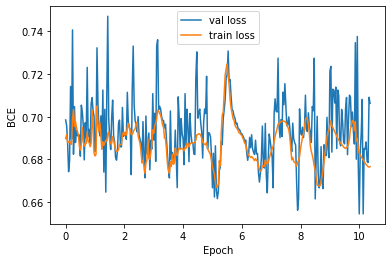

In [22]:
epochs = [x/batch_size for x in range(len(loss_train))]
plt.plot(epochs, loss_train, label="val loss")
plt.plot(epochs, loss_val, label="train loss")
plt.ylabel("BCE")
plt.xlabel("Epoch")
plt.legend()

## Get accuracy

In [40]:
pred = np.round(net.predict(X_val),0) # round to nearest integer
accuracy = np.sum(np.where(pred == y_val, 1, 0)[0]) / len(pred)
print(accuracy)

0.5636363636363636
